In [1]:
import os
import torch
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_fscore_support, brier_score_loss
from datasets import DatasetDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

c:\Users\aleja\Documents\github\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [3]:
machines_files = glob('../data/machine/*.jsonl')
len(machines_files)

13

In [4]:
df_ids = pd.read_json('../data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


In [5]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape

((760, 1), (218, 1), (109, 1))

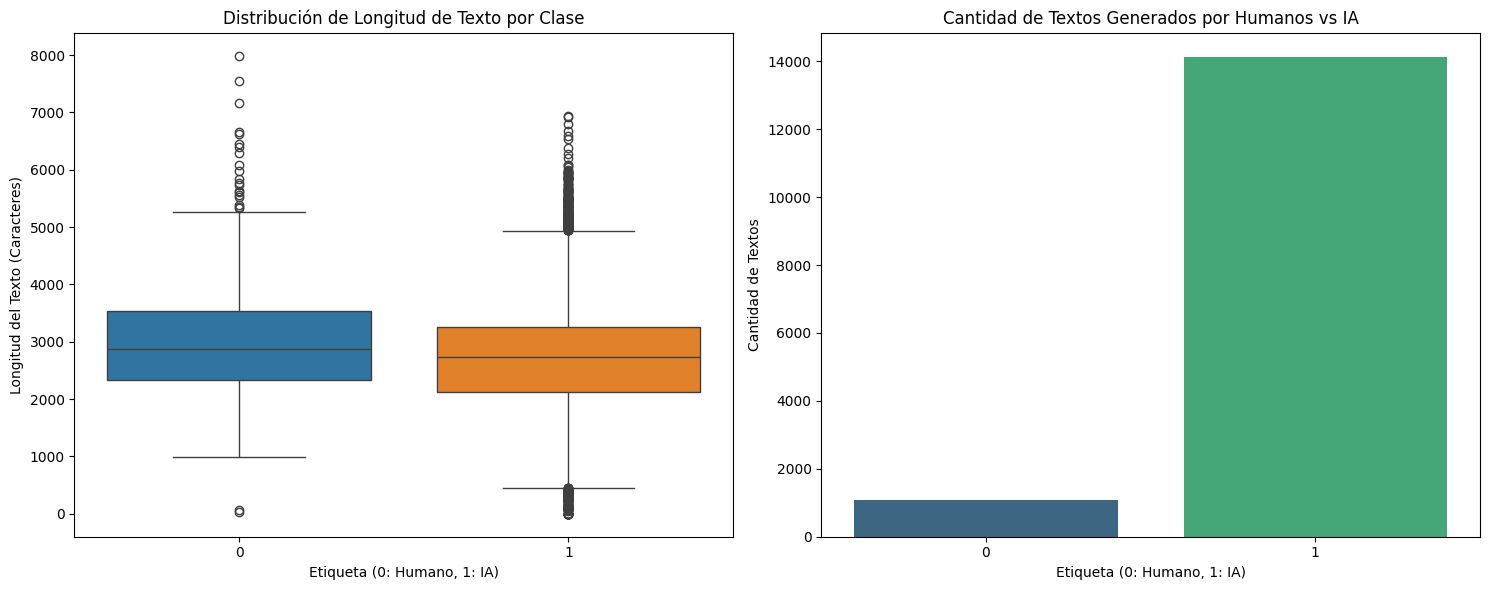

In [6]:
df_human = pd.read_json('../data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1


df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

# Calcular la longitud del texto en la columna 'text'
df_temp["text_length"] = df_temp["text"].apply(len)

# Crear una figura con 2 subgráficos (uno al lado del otro)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de la longitud del texto (sin `palette`)
sns.boxplot(data=df_temp, x="label", hue="label",y="text_length", ax=ax[0], legend=False)
ax[0].set_title("Distribución de Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de la cantidad de texto generado por IA y Humanos
sns.countplot(data=df_temp, x="label", hue="label", palette="viridis", ax=ax[1], legend=False)
ax[1].set_title("Cantidad de Textos Generados por Humanos vs IA")
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[1].set_ylabel("Cantidad de Textos")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [7]:
df_human["id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine["id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))
df_combined['target_human'] = 1
df_combined['target_machine'] = 0
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]
df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


In [8]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,"(1, 0)"
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


In [9]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape

((9880, 3), (2834, 3), (1417, 3))

In [10]:
X_train.sample(5)

,text_1,text_2,target_tuple
2571,Biden Issues National Security Memo to Bolster...,Biden Issues National Security Memorandum On C...,"(0, 1)"
13498,Vistra says Texas February freeze cost about $...,Vistra Corp Raises Winter Storm Uri Cost Estim...,"(1, 0)"
1903,Fox News Channel's Sean Hannity Has The Week's...,"Sean Hannity Dominates Cable News Ratings, Top...","(1, 0)"
1241,Citibank accidentally wired $500m back to lend...,Citibank Unable to Reclaim $500m Accidentally ...,"(1, 0)"
13815,Gabrielle 'Gabby' Petito's Disappearance Unrel...,Authorities rule out link between Gabby Petito...,"(0, 1)"


In [11]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9880,), (2834,), (1417,))

In [12]:
X_train

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."
...,...,...
14100,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...
14101,TESLA STOCK SOARS ON Q3 EARNINGS REPORT\n\nWYO...,Univ. of Wisconsin Oshkosh student helping Gab...
14102,WYOMING (WBAY) – A University of Wisconsin Osh...,Univ. of Wisconsin Oshkosh student helping Gab...
14103,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...


In [13]:
pd.DataFrame(y_train)

,target_tuple
0,"(0, 1)"
1,"(1, 0)"
2,"(1, 0)"
3,"(0, 1)"
4,"(1, 0)"
...,...
14100,"(1, 0)"
14101,"(0, 1)"
14102,"(0, 1)"
14103,"(1, 0)"


In [14]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use iloc to access the rows by index for data and labels
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]  # assuming labels are in a compatible format
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

In [ ]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        # Organizar los datos por columna
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Procesar text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Procesar text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        # Tokenización individual de text_1
        inputs_text_1 = self.tokenizer(
            comment_text_1,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        # Tokenización individual de text_2
        inputs_text_2 = self.tokenizer(
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids_1': torch.tensor(inputs_text_1['input_ids'], dtype=torch.long),
            'mask_1': torch.tensor(inputs_text_1['attention_mask'], dtype=torch.long),
            'token_type_ids_1': torch.tensor(inputs_text_1['token_type_ids'], dtype=torch.long),
            'ids_2': torch.tensor(inputs_text_2['input_ids'], dtype=torch.long),
            'mask_2': torch.tensor(inputs_text_2['attention_mask'], dtype=torch.long),
            'token_type_ids_2': torch.tensor(inputs_text_2['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float) 
        }

In [16]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

In [17]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [ ]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

Training Loader Batch:
ids_1: torch.Size([32, 512])
mask_1: torch.Size([32, 512])
token_type_ids_1: torch.Size([32, 512])
ids_2: torch.Size([32, 512])
mask_2: torch.Size([32, 512])
token_type_ids_2: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids_1: torch.Size([32, 512])
mask_1: torch.Size([32, 512])
token_type_ids_1: torch.Size([32, 512])
ids_2: torch.Size([32, 512])
mask_2: torch.Size([32, 512])
token_type_ids_2: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids_1: torch.Size([32, 512])
mask_1: torch.Size([32, 512])
token_type_ids_1: torch.Size([32, 512])
ids_2: torch.Size([32, 512])
mask_2: torch.Size([32, 512])
token_type_ids_2: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [19]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('google-bert/bert-large-uncased')
        self.dropout = torch.nn.Dropout(0.3)
        self.fc1 = torch.nn.Linear(1024, 256)  # Proyectamos la salida de BERT a 256 dimensiones

    def forward(self, ids, mask, token_type_ids):
        # Pasamos los datos a través de BERT
        last_hidden_state = self.bert(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state
        
        # Usamos el token [CLS] para obtener la representación del texto
        cls_token = last_hidden_state[:, 0]  # El token [CLS] está en la posición 0
        representation = F.gelu(self.fc1(self.dropout(cls_token)))

        return representation


class SiameseNetwork(torch.nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # Modelo compartido para procesar los textos
        self.transformer = TransformerClass()

        # Capa final para clasificar el par de textos
        # Concatenaremos las representaciones -> 256 + 256 = 512
        self.fc_final = torch.nn.Sequential(
            torch.nn.Linear(256 * 2, 128),  
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(128, 2)  
        )

    def forward_once(self, ids, mask, token_type_ids):
        return self.transformer(ids, mask, token_type_ids)

    def forward(self, ids1, mask1, token_type_ids1, ids2, mask2, token_type_ids2):
        # Representación del primer texto
        representation1 = self.forward_once(ids1, mask1, token_type_ids1)
        
        # Representación del segundo texto
        representation2 = self.forward_once(ids2, mask2, token_type_ids2)

        # Concatenamos las representaciones
        concatenated_representation = torch.cat((representation1, representation2), dim=1)

        # Clasificación final basada en la representación combinada
        output = self.fc_final(concatenated_representation)

        return output

In [20]:
def training_step(ids_1, mask_1, token_type_ids_1, ids_2, mask_2, token_type_ids_2, targets, model, optimizer):
    optimizer.zero_grad()
    logits = model(ids_1, mask_1, token_type_ids_1, ids_2, mask_2, token_type_ids_2)
    loss = torch.nn.functional.cross_entropy(logits, targets, reduction='sum')
    loss.backward()
    optimizer.step()
    return loss

In [21]:
model = SiameseNetwork()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [22]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            ids_1 = data['ids_1'].to(device)
            mask_1 = data['mask_1'].to(device)
            token_type_ids_1 = data['token_type_ids_1'].to(device)
            ids_2 = data['ids_2'].to(device)
            mask_2 = data['mask_2'].to(device)
            token_type_ids_2 = data['token_type_ids_2'].to(device)
            targets = data['targets'].to(device)

            logits = model(ids_1, mask_1, token_type_ids_1, ids_2, mask_2, token_type_ids_2)
            
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy

In [23]:
log_file_path = './training_log.txt'

def log_message(message):
    with open(log_file_path, 'a') as log_file:
        log_file.write(message + '\n')
    print(message)

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        ids_1 = data['ids_1'].to(device)
        mask_1 = data['mask_1'].to(device)
        token_type_ids_1 = data['token_type_ids_1'].to(device)
        ids_2 = data['ids_2'].to(device)
        mask_2 = data['mask_2'].to(device)
        token_type_ids_2 = data['token_type_ids_2'].to(device)
        targets = data['targets'].to(device)

        # Llamada al paso de entrenamiento
        loss = training_step(ids_1, mask_1, token_type_ids_1, ids_2, mask_2, token_type_ids_2, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            log_message(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            log_message(f"  Running Loss: {avg_loss:.4f}")

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    log_message(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    log_message(f"  Training Loss: {avg_train_loss:.4f}")
    log_message(f"  Validation Loss: {avg_val_loss:.4f}")
    log_message(f"  Validation Accuracy: {val_accuracy:.4f}")

    # Guardar el modelo si se logra la mejor precisión
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        log_message(f"Model saved to {model_save_path}")


best_accuracy = 0

# Al iniciar, limpia el archivo de log si ya existe
if os.path.exists(log_file_path):
    open(log_file_path, 'w').close()

# Entrenar el modelo
# for epoch in range(EPOCHS):
#     train(epoch)

# Leer y mostrar el log de entrenamiento
file_path = '../logs/Siameses_BERT_L_training_logs.txt'
with open(file_path, 'r') as file:
    content = file.read()

print(content)

Epoch 1/4, Step 1/309
  Running Loss: 0.6910
Epoch 1/4, Step 201/309
  Running Loss: 0.1787
Epoch 1/4 - End of epoch
  Training Loss: 0.1202
  Validation Loss: 0.1054
  Validation Accuracy: 0.9608
Model saved to ./model_weights/model_epoch_1_acc0.9608.pth
Epoch 2/4, Step 1/309
  Running Loss: 0.0073
Epoch 2/4, Step 201/309
  Running Loss: 0.0046
Epoch 2/4 - End of epoch
  Training Loss: 0.0039
  Validation Loss: 0.0637
  Validation Accuracy: 0.9894
Model saved to ./model_weights/model_epoch_2_acc0.9894.pth
Epoch 3/4, Step 1/309
  Running Loss: 0.0017
Epoch 3/4, Step 201/309
  Running Loss: 0.0014
Epoch 3/4 - End of epoch
  Training Loss: 0.0016
  Validation Loss: 0.0582
  Validation Accuracy: 0.9809
Epoch 4/4, Step 1/309
  Running Loss: 0.0009
Epoch 4/4, Step 201/309
  Running Loss: 0.0007
Epoch 4/4 - End of epoch
  Training Loss: 0.0006
  Validation Loss: 0.0898
  Validation Accuracy: 0.9651



In [24]:
model = SiameseNetwork()

model_save_path = f'..\model_weights\Siameses_BERT_L_CLS\model_epoch_2_acc0.9894.pth'
model.load_state_dict(torch.load(model_save_path, weights_only=False))

model.to(device)

SiameseNetwork(
  (transformer): TransformerClass(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-23): 24 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=1024, out_featu

In [25]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    all_targets = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for data in test_loader:
            ids_1 = data['ids_1'].to(device)
            mask_1 = data['mask_1'].to(device)
            token_type_ids_1 = data['token_type_ids_1'].to(device)
            ids_2 = data['ids_2'].to(device)
            mask_2 = data['mask_2'].to(device)
            token_type_ids_2 = data['token_type_ids_2'].to(device)
            targets = data['targets'].to(device)

            # Si los objetivos están en formato one-hot, conviértelos
            if targets.dim() > 1:  # Si targets tiene más de 1 dimensión (e.g., [batch_size, num_classes])
                targets = torch.argmax(targets, dim=1)

            # Forward pass
            logits = model(ids_1, mask_1, token_type_ids_1, ids_2, mask_2, token_type_ids_2)

            # Calcula la pérdida
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones y probabilidades
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

            # Acumulamos
            all_probs.extend(probs.cpu().numpy()[:, 1])  # Probabilidades de clase positiva
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            correct_predictions += (preds == targets).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions

    # Métricas adicionales
    roc_auc = roc_auc_score(all_targets, all_probs)
    brier = brier_score_loss(all_targets, all_probs)
    f1 = f1_score(all_targets, all_preds, average='weighted')  # Ajusta el promedio si es necesario
    f05 = precision_recall_fscore_support(all_targets, all_preds, average='weighted', beta=0.5)[2]

    # C@1
    correct = sum(1 for t, p in zip(all_targets, all_preds) if t == p)
    c_at_1 = correct / len(all_preds)

    return avg_test_loss, accuracy, roc_auc, brier, c_at_1, f1, f05

test_loss, test_accuracy, roc_auc, brier, c_at_1, f1, f05 = test(test_loader, model, device)

In [26]:
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"C@1: {c_at_1:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"F0.5 Score: {f05:.4f}")

Test Loss: 0.0755
Test Accuracy: 0.9908
ROC-AUC: 1.0000
Brier Score: 0.0207
C@1: 0.9908
F1 Score: 0.9908
F0.5 Score: 0.9909
